In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC,
DecisionTreeRegressor as DTR,
plot_tree,
export_text)
from sklearn.metrics import (accuracy_score,
log_loss)
from sklearn.ensemble import \
(RandomForestRegressor as RF,
GradientBoostingRegressor as GBR,
GradientBoostingClassifier as GBC)
from ISLP.bart import BART
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from sklearn.cluster import \
(KMeans,
AgglomerativeClustering)
from scipy.cluster.hierarchy import \
(dendrogram,
cut_tree)
from ISLP.cluster import compute_linkage
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
from ISLP import load_data, confusion_table
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay
from scipy import stats
import seaborn as sns

In [82]:
import statsmodels.api as sm

## Exploratory Data Analysis

### SBP and DBP for Sex

In [3]:
data = pd.read_csv("503data.csv")
## We first drop the SEQN 
data = data.drop(columns = ['SEQN'])

In [4]:
data

,RIAGENDR,RIDAGEYR,DSD010,DSDCOUNT,BMXBMI,ALQ130,SMQ020,INDFMMPI,BPXOSY,BPXODI
0,2,29,2,0,37.8,1,2,5.00,99.000000,54.333333
1,1,68,1,1,30.2,2,2,1.20,134.000000,70.000000
2,1,58,1,2,30.5,6,2,1.81,138.000000,97.000000
3,1,55,2,0,20.9,1,2,5.00,119.666667,75.000000
4,2,48,1,3,23.9,1,2,4.89,104.000000,62.333333
...,...,...,...,...,...,...,...,...,...,...
4392,1,64,2,0,37.5,2,1,1.15,138.666667,86.666667
4393,1,52,2,0,29.5,1,1,1.48,140.000000,86.666667
4394,2,67,1,2,37.9,2,2,1.82,112.000000,67.333333
4395,1,40,1,1,38.2,2,2,3.82,103.000000,67.333333


In [5]:
### Find the dimension of data
print("The number of observations is :", np.shape(data)[0])

The number of observations is : 4397


In [6]:
## Find the number of male and female in our data set
print("Number of male is:",np.shape(data[data["RIAGENDR"] == 1])[0],
      "Number of female is:", np.shape(data[data["RIAGENDR"] == 2])[0])

Number of male is: 2239 Number of female is: 2158


Thus, we have totally 2239 males and 2158 females in our data set. 

We may now want to explore what is the distribution of BPXOSY and BPXODI between male and female two see if there is any pattern between sex

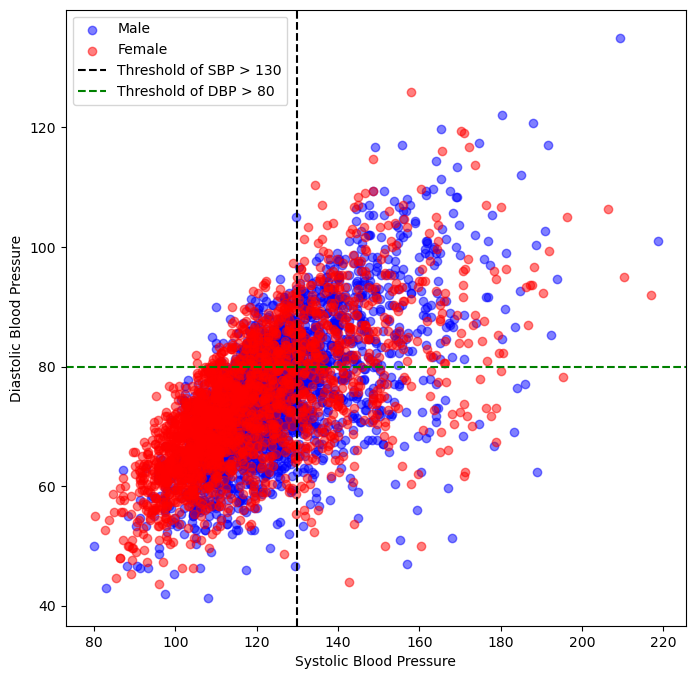

In [7]:
data_male = data[data["RIAGENDR"] == 1]
data_female = data[data["RIAGENDR"] == 2]

fig, ax = plt.subplots(figsize = (8, 8))
plt.scatter(data_male["BPXOSY"], data_male["BPXODI"], facecolor = "blue", label = "Male", alpha = 0.5)
plt.scatter(data_female["BPXOSY"], data_female["BPXODI"], facecolor = "red", label = "Female", alpha = 0.5)
plt.xlabel("Systolic Blood Pressure")
plt.ylabel("Diastolic Blood Pressure")
plt.axvline(x = 130, color = "black", linestyle = '--', label = "Threshold of SBP > 130")
plt.axhline(y = 80, color = 'green', linestyle = '--', label = "Threshold of DBP > 80")
plt.legend()

In [8]:
print("Mean of SBP for male:", np.mean(data_male["BPXOSY"]),
        "Mean of SBP for female:", np.mean(data_female["BPXOSY"]))

Mean of SBP for male: 125.9507220485336 Mean of SBP for female: 119.06765523632994


In [9]:
print("Sd of SBP for male:", np.std(data_male["BPXOSY"]),
        "Sd of SBP for female:", np.std(data_female["BPXOSY"]))

Sd of SBP for male: 16.607162001233387 Sd of SBP for female: 19.08474602104655


We can now present two sample t-test to find if different sex have same average SBP and DBP

In [10]:
t_stats_sbp, p_value_sbp = stats.ttest_ind(data_male["BPXOSY"], 
                                           data_female["BPXOSY"], equal_var = False)
print("t-stats for SBP:", t_stats_sbp, "p-value for SBP:", p_value_sbp)

t-stats for SBP: 12.735670781368935 p-value for SBP: 1.717464949617433e-36


Thus,we will reject the null hypothesis that male and female have same SBP under unknown variance. We do the same thing for DBP

In [11]:
print("Mean of DBP for male:", np.mean(data_male["BPXODI"]),
        "Mean of DBP for female:", np.mean(data_female["BPXODI"]))

Mean of DBP for male: 75.7988685425041 Mean of DBP for female: 73.50880444856348


In [12]:
print("Sd of DBP for male:", np.std(data_male["BPXODI"]),
        "Sd of DBP for female:", np.std(data_female["BPXODI"]))

Sd of DBP for male: 11.56993183317537 Sd of DBP for female: 11.306638668298168


In [13]:
t_stats_dbp, p_value_dbp = stats.ttest_ind(data_male["BPXODI"], 
                                           data_female["BPXODI"], equal_var = False)
print("t-stats for DBP:", t_stats_dbp, "p-value for SBP:", p_value_dbp)

t-stats for DBP: 6.63629609185746 p-value for SBP: 3.607051064287284e-11


Thus, we also reject the null hypothesis that male and female have same DPB under unknown variance.

### BMI 

In [14]:
print("Mean of BMI:", np.mean(data["BMXBMI"]), 
      "Sd of BMI:", np.std(data["BMXBMI"]),"\n",
      "Max of BMI:", np.max(data["BMXBMI"]),
      "Min of BMI:", np.min(data["BMXBMI"]))

Mean of BMI: 29.996179213099836 Sd of BMI: 7.568143554660437 
 Max of BMI: 80.6 Min of BMI: 14.6


compute basic statistics of BMI for male and female

Male

In [15]:
print("Mean of BMI:", np.mean(data_male["BMXBMI"]), 
      "Sd of BMI:", np.std(data_male["BMXBMI"]),"\n",
      "Max of BMI:", np.max(data_male["BMXBMI"]),
      "Min of BMI:", np.min(data_male["BMXBMI"]))

Mean of BMI: 29.394953104064317 Sd of BMI: 6.413652009517309 
 Max of BMI: 68.2 Min of BMI: 14.9


Female

In [16]:
print("Mean of BMI:", np.mean(data_female["BMXBMI"]), 
      "Sd of BMI:", np.std(data_female["BMXBMI"]),"\n",
      "Max of BMI:", np.max(data_female["BMXBMI"]),
      "Min of BMI:", np.min(data_female["BMXBMI"]))

Mean of BMI: 30.61997219647822 Sd of BMI: 8.55922801681892 
 Max of BMI: 80.6 Min of BMI: 14.6


Text(0, 0.5, 'Systolic Blood Pressure')

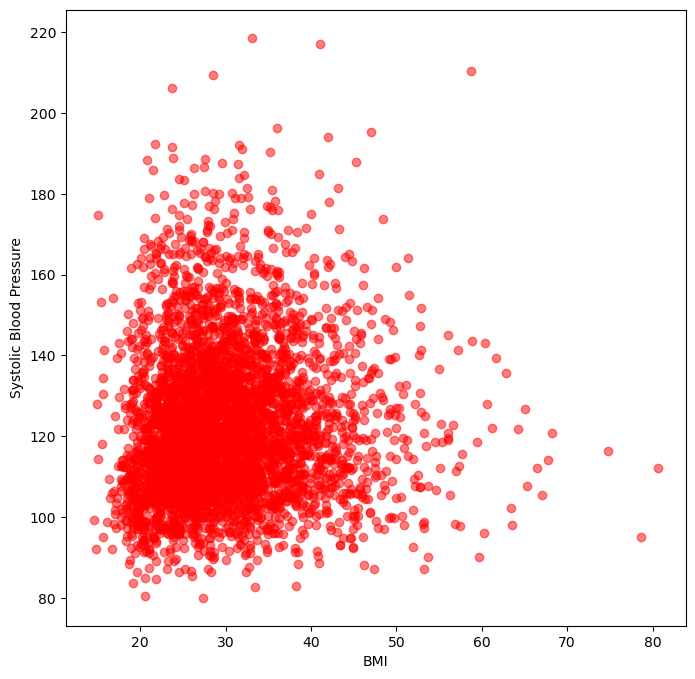

In [17]:
fig, ax = plt.subplots(figsize = (8, 8))
plt.scatter(data["BMXBMI"], data["BPXOSY"], facecolor = 'red', alpha = 0.5)
plt.xlabel("BMI")
plt.ylabel("Systolic Blood Pressure")

Text(0, 0.5, 'Diastolic Blood Pressure')

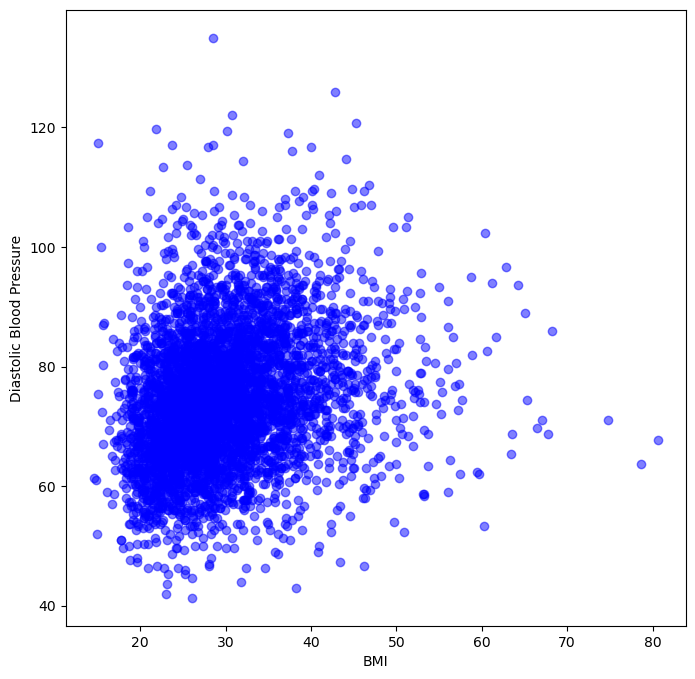

In [18]:
fig, ax = plt.subplots(figsize = (8, 8))
plt.scatter(data["BMXBMI"], data["BPXODI"], facecolor = 'blue', alpha = 0.5)
plt.xlabel("BMI")
plt.ylabel("Diastolic Blood Pressure")

### Family monthly poverty level index

In [19]:
print("Mean of INDFMMPI:", np.mean(data["INDFMMPI"]), 
      "Sd of INDFMMPI:", np.std(data["INDFMMPI"]),"\n",
      "Max of INDFMMPI:", np.max(data["INDFMMPI"]),
      "Min of INDFMMPI:", np.min(data["INDFMMPI"]))

Mean of INDFMMPI: 2.51424835114851 Sd of INDFMMPI: 1.5970464296130777 
 Max of INDFMMPI: 5.0 Min of INDFMMPI: 0.0


Male

In [20]:
print("Mean of INDFMMPI:", np.mean(data_male["INDFMMPI"]), 
      "Sd of INDFMMPI:", np.std(data_male["INDFMMPI"]),"\n",
      "Max of INDFMMPI:", np.max(data_male["INDFMMPI"]),
      "Min of INDFMMPI:", np.min(data_male["INDFMMPI"]))

Mean of INDFMMPI: 2.5764046449307725 Sd of INDFMMPI: 1.6087650935186382 
 Max of INDFMMPI: 5.0 Min of INDFMMPI: 0.0


In [21]:
print("Mean of INDFMMPI:", np.mean(data_female["INDFMMPI"]), 
      "Sd of INDFMMPI:", np.std(data_female["INDFMMPI"]),"\n",
      "Max of INDFMMPI:", np.max(data_female["INDFMMPI"]),
      "Min of INDFMMPI:", np.min(data_female["INDFMMPI"]))

Mean of INDFMMPI: 2.4497590361445782 Sd of INDFMMPI: 1.5822174574967904 
 Max of INDFMMPI: 5.0 Min of INDFMMPI: 0.0


Text(0, 0.5, 'Systolic Blood Pressure')

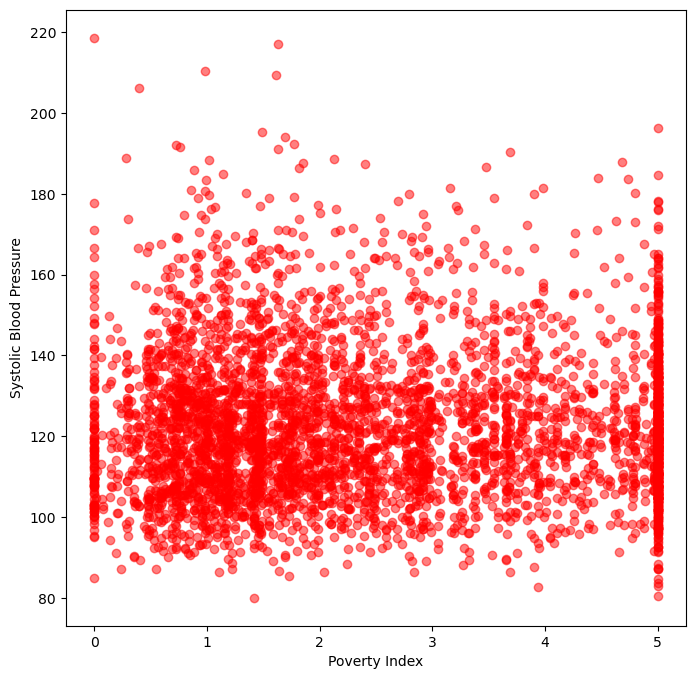

In [22]:
fig, ax = plt.subplots(figsize = (8, 8))
plt.scatter(data["INDFMMPI"], data["BPXOSY"], facecolor = 'red', alpha = 0.5)
plt.xlabel("Poverty Index")
plt.ylabel("Systolic Blood Pressure")

Text(0, 0.5, 'Diastolic Blood Pressure')

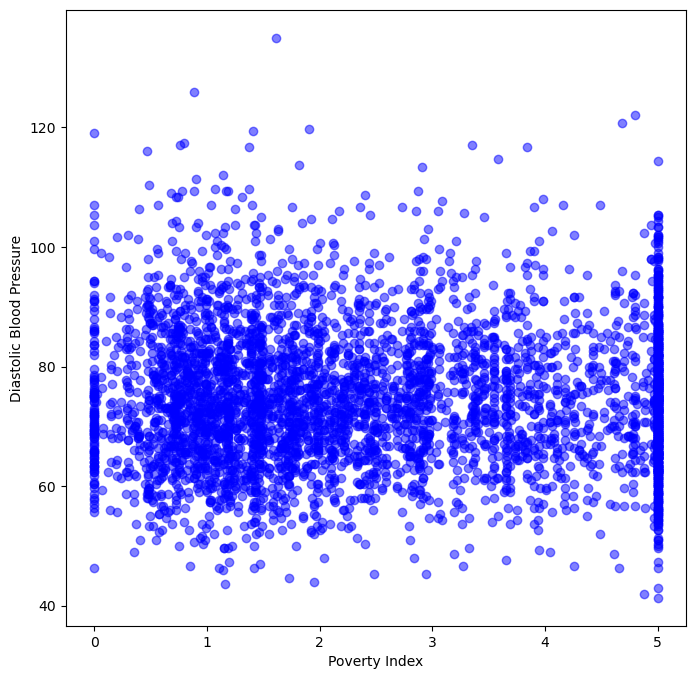

In [23]:
fig, ax = plt.subplots(figsize = (8, 8))
plt.scatter(data["INDFMMPI"], data["BPXODI"], facecolor = 'blue', alpha = 0.5)
plt.xlabel("Poverty Index")
plt.ylabel("Diastolic Blood Pressure")

We now want to find the correlation matrix between continuous variables

In [24]:
selected_columns = ["BPXOSY", "BPXODI", "RIDAGEYR", "BMXBMI", "INDFMMPI"]
correlation_matrix = data[selected_columns].corr()
print(correlation_matrix)

            BPXOSY    BPXODI  RIDAGEYR    BMXBMI  INDFMMPI
BPXOSY    1.000000  0.652238  0.445452  0.062470 -0.005474
BPXODI    0.652238  1.000000  0.090629  0.232648 -0.019861
RIDAGEYR  0.445452  0.090629  1.000000  0.045217  0.141366
BMXBMI    0.062470  0.232648  0.045217  1.000000 -0.048060
INDFMMPI -0.005474 -0.019861  0.141366 -0.048060  1.000000


We can now try to find blood pressure difference between people who smoke more than 100 and less than 100

In [25]:
data_smoke_1 = data[data["SMQ020"] == 1]
data_smoke_2 = data[data["SMQ020"] == 2]

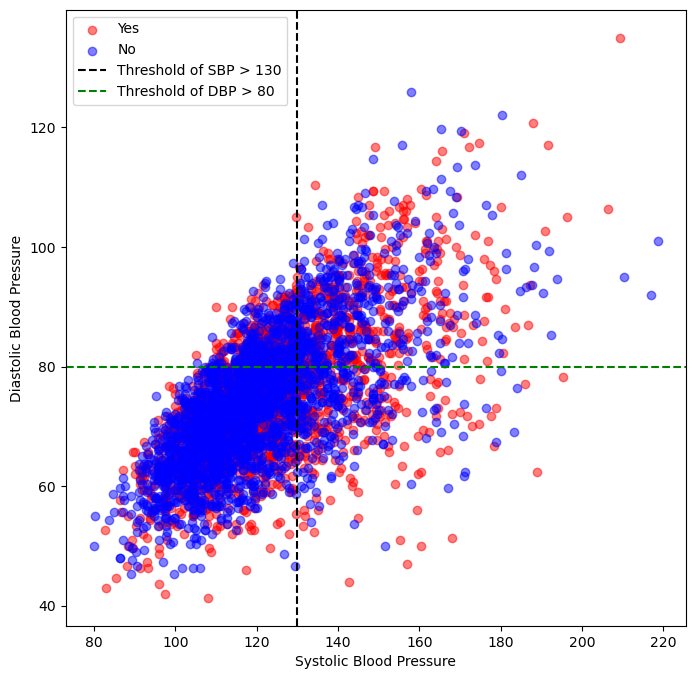

In [26]:
ax, fig = plt.subplots(figsize = (8, 8))
plt.scatter(data_smoke_1["BPXOSY"], data_smoke_1["BPXODI"], 
            facecolor = 'red', alpha = 0.5, label = "Yes")
plt.scatter(data_smoke_2["BPXOSY"], data_smoke_2["BPXODI"], 
            facecolor = 'blue', alpha = 0.5, label = "No")
plt.xlabel("Systolic Blood Pressure")
plt.ylabel("Diastolic Blood Pressure")
plt.axvline(x = 130, color = "black", linestyle = '--', label = "Threshold of SBP > 130")
plt.axhline(y = 80, color = 'green', linestyle = '--', label = "Threshold of DBP > 80")
plt.legend()

In [27]:
t_stats_smoke_sy, p_value_smoke_sy = stats.ttest_ind(data_smoke_1["BPXOSY"], 
                                           data_smoke_2["BPXOSY"], equal_var = False)
print("t-stats for SBP:", t_stats_smoke_sy, "p-value for SBP:", p_value_smoke_sy)

t-stats for SBP: 7.779689931918986 p-value for SBP: 9.171859588224484e-15


In [28]:
t_stats_smoke_di, p_value_smoke_di = stats.ttest_ind(data_smoke_1["BPXODI"], 
                                           data_smoke_2["BPXODI"], equal_var = False)
print("t-stats for SBP:", t_stats_smoke_di, "p-value for SBP:", p_value_smoke_di)

t-stats for SBP: 4.388765486844361 p-value for SBP: 1.1693289941953287e-05


## Create Dummy Variable that is Non-Hypertension or Hypertension

In [29]:
hyper = np.zeros((np.shape(data)[0], 1))
for i in range(np.shape(data)[0]):
    if data["BPXOSY"][i] >= 130 or data["BPXODI"][i] >= 80:
        hyper[i] = 1
    else:
        hyper[i] = 0

In [30]:
data["HYPER"] = hyper

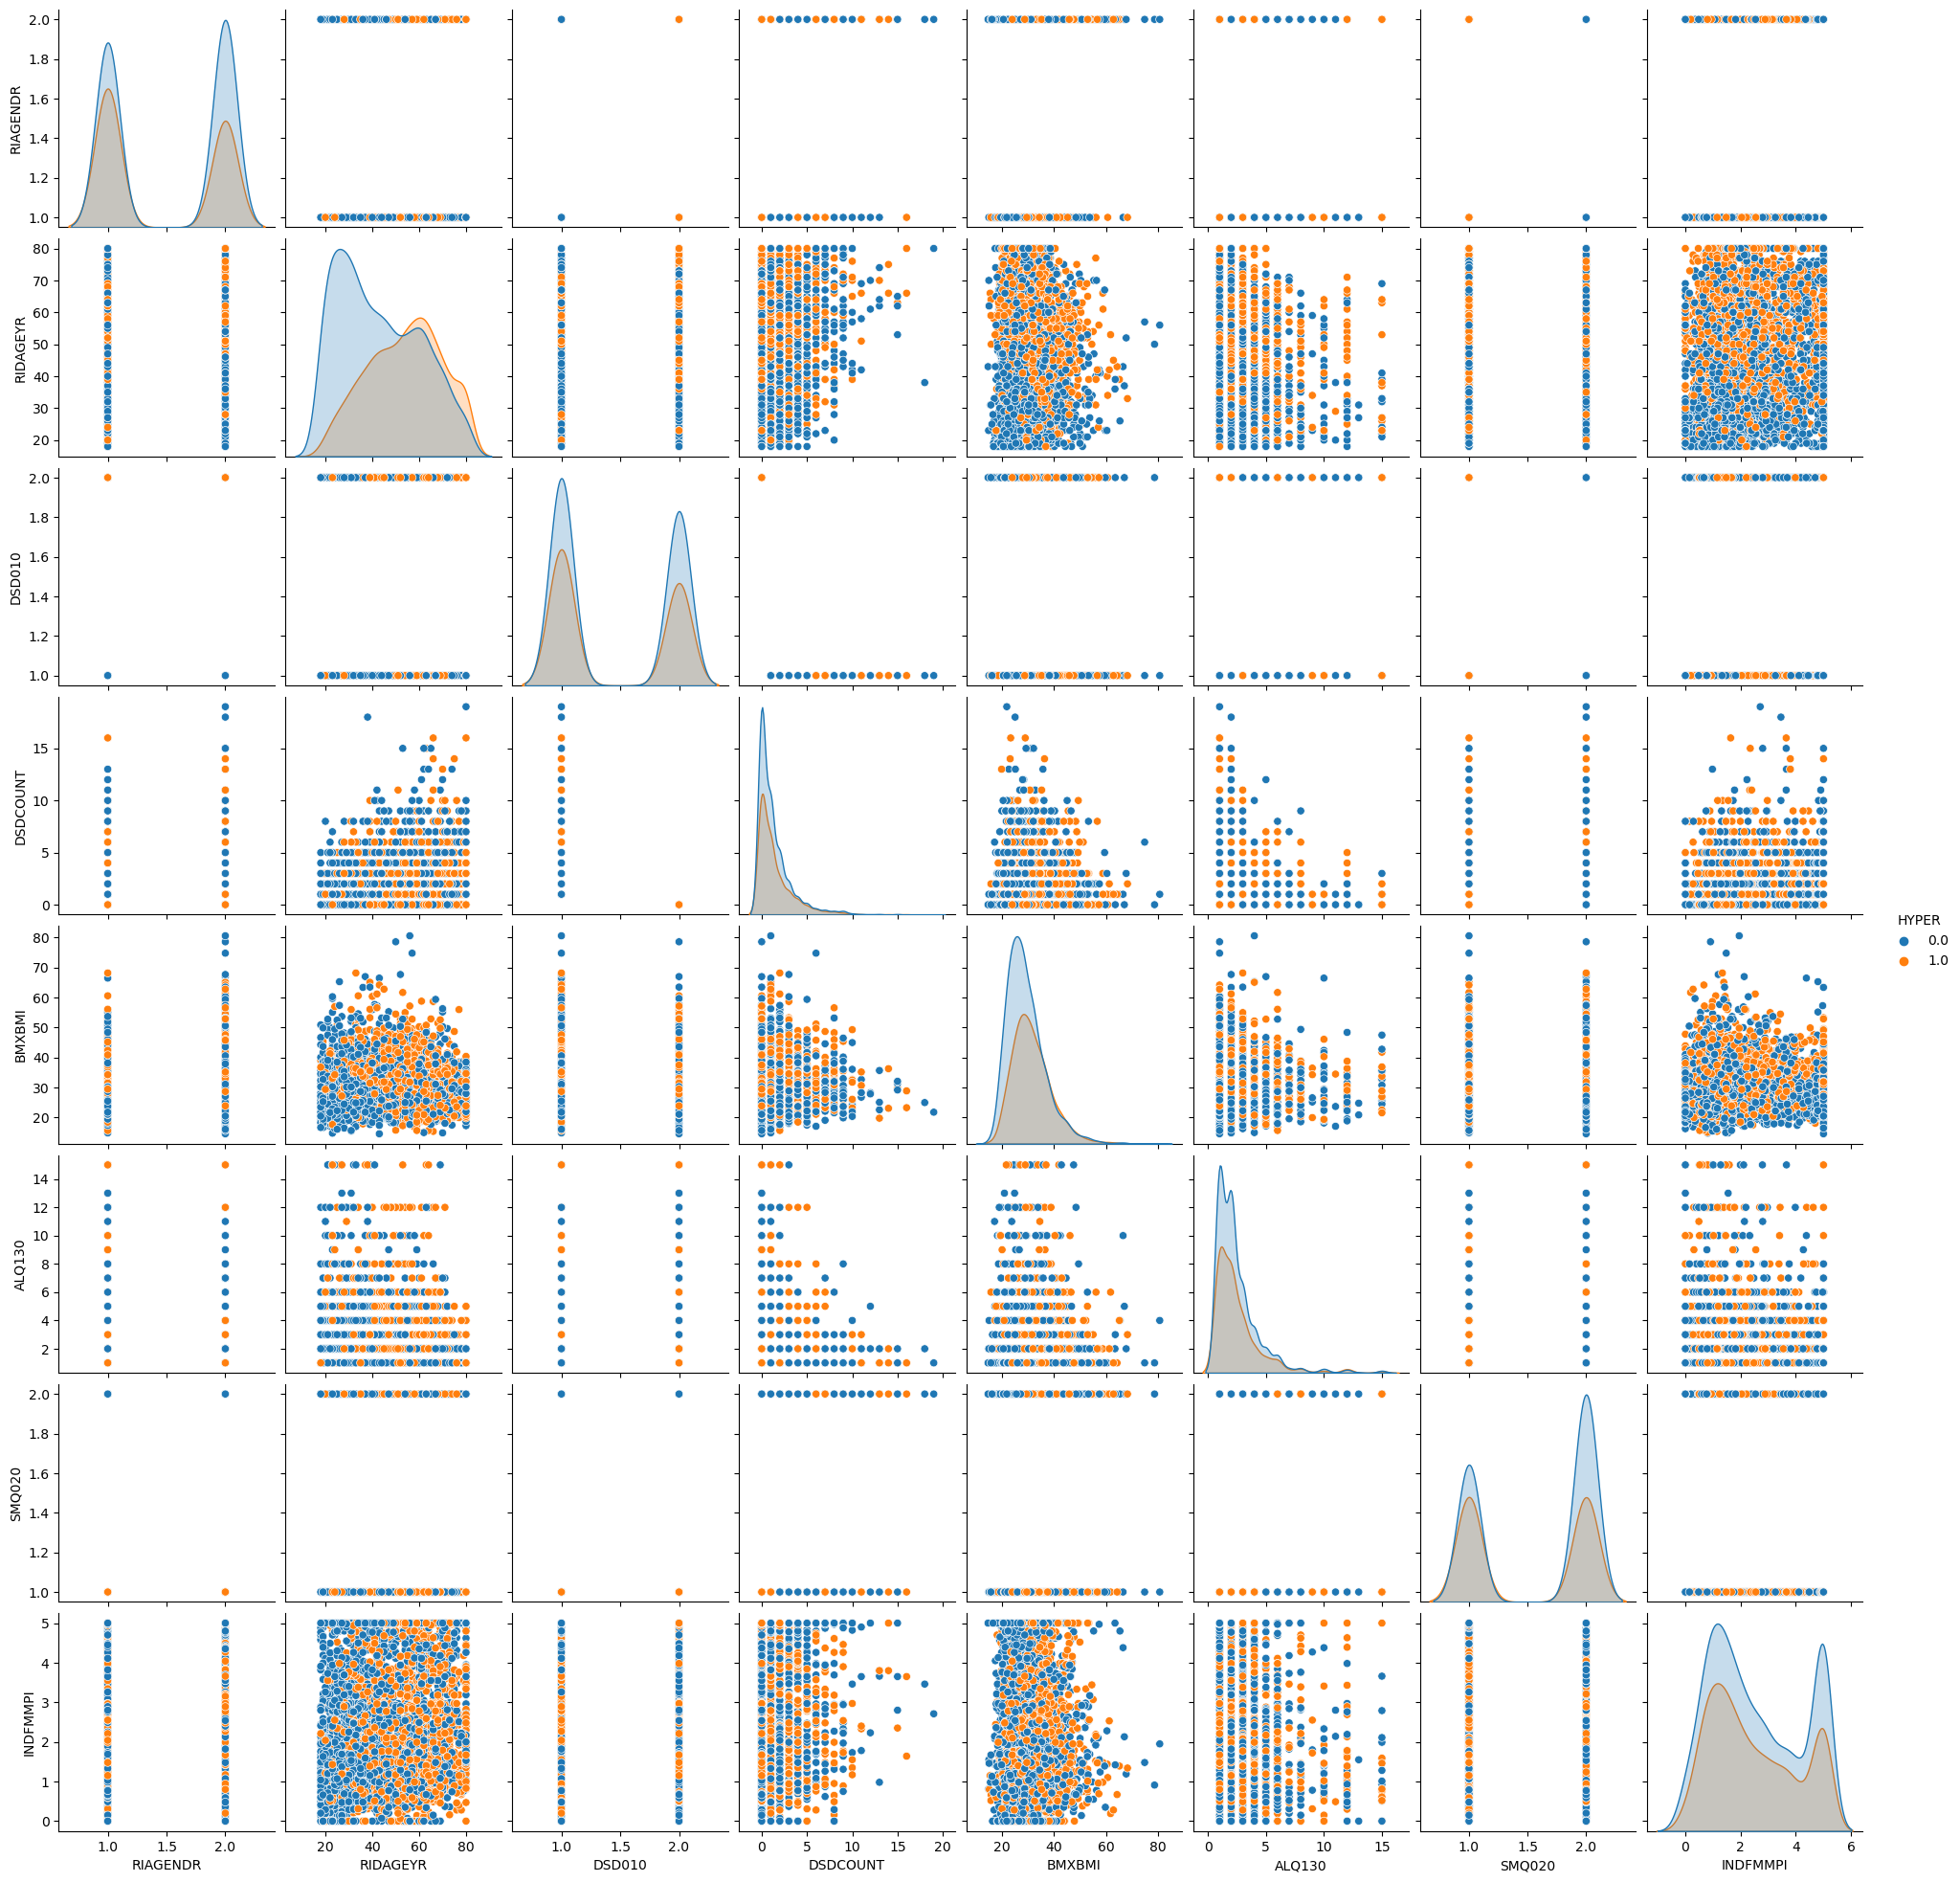

In [31]:
sns.pairplot(data[['RIAGENDR', 'RIDAGEYR', 'DSD010', 'DSDCOUNT', 'BMXBMI', 'ALQ130', 'SMQ020', 
                   'INDFMMPI', 'HYPER']], hue = 'HYPER')

### Split our data into hyper = 1 and hyper = 0 to do furthur expolatory data analysis

In [32]:
data_hyper0 = data[data["HYPER"] == 0]
data_hyper1 = data[data["HYPER"] == 1]

In [33]:
### Do the two sample t-test to check if mean of BMI for two populations are the same under unknown variance
t_stat_bmi, p_value_bmi = stats.ttest_ind(data_hyper0["BMXBMI"],
                                          data_hyper1["BMXBMI"], equal_var=False)
print("t_stat for bmi between two groups:", t_stat_bmi,
      "p-values for bmi between two groups", p_value_bmi)

t_stat for bmi between two groups: -9.848230063863216 p-values for bmi between two groups 1.2967877263063812e-22


In [34]:
### Do the two sample t-test to check if mean of age for two populations are the same under unknown variance
t_stat_age, p_value_age = stats.ttest_ind(data_hyper0["RIDAGEYR"],
                                          data_hyper1["RIDAGEYR"], equal_var = False)
print("t_stat for age between two groups:", t_stat_age,
      "p-values for age between two groups", p_value_age)

t_stat for age between two groups: -21.695785132353773 p-values for age between two groups 8.128241613186986e-99


In [35]:
### Do the two sample t-test to check if mean of alcohol use for two populations are the same under unknown variance
t_stat_alco, p_value_alco = stats.ttest_ind(data_hyper0["ALQ130"],
                                          data_hyper1["ALQ130"], equal_var = False)
print("t_stat for alcohol use between two groups:", t_stat_alco,
      "p-values for alcohol use between two groups", p_value_alco)

t_stat for alcohol use between two groups: -1.6021042652311799 p-values for alcohol use between two groups 0.10922174289866082


In [36]:
### Do the two sample t-test to check if mean of poverty index use for two populations are the same under unknown variance
t_stat_pover, p_value_pover = stats.ttest_ind(data_hyper0["INDFMMPI"],
                                          data_hyper1["INDFMMPI"], equal_var = False)
print("t_stat for poverty index between two groups:", t_stat_pover,
      "p-values for poverty index between two groups", p_value_pover)

t_stat for poverty index between two groups: 1.7355608042969533 p-values for poverty index between two groups 0.08272056346358136


In [37]:
from statsmodels.stats.proportion import proportions_ztest

### Proportion test for categorical variables 
#### Gender

In [38]:
### Now do proportional_ztest for categorical variables
count_male_0 = np.shape(data_hyper0[data_hyper0["RIAGENDR"] == 1])[0]
count_female_0 = np.shape(data_hyper0[data_hyper0["RIAGENDR"] == 2])[0]

count_male = np.shape(data_male)[0]
count_female = np.shape(data_female)[0]

print("number of male with hyper = 0:", count_male_0, "number of female with hyper = 0:", count_female_0,
      "Total number of male:", count_male, "Total number of female:", count_female, "\n")

### Perform proportion test
stat_gender, pval_gender = proportions_ztest([count_male_0, count_female_0],
                                             [count_male, count_female])
print("stat : ", stat_gender, "p-value for gender:", pval_gender)

number of male with hyper = 0: 1239 number of female with hyper = 0: 1390 Total number of male: 2239 Total number of female: 2158 

stat :  -6.134895024477094 p-value for gender: 8.521544529784751e-10


#### DSD010

In [39]:
### Now do proportional_ztest for categorical variables
count_DSD1_0 = np.shape(data_hyper0[data_hyper0["DSD010"] == 1])[0]
count_DSD2_0 = np.shape(data_hyper0[data_hyper0["DSD010"] == 2])[0]

count_DSD1 = np.shape(data[data["DSD010"] == 1])[0]
count_DSD2 = np.shape(data[data["DSD010"] == 2])[0]

print("number of taken DS with hyper = 0:", count_DSD1_0, "number of not taken DS with hyper = 0:", count_DSD2_0,
      "Total number of taken DS:", count_DSD1, "Total number of not taken DS:", count_DSD2, "\n")

### Perform proportion test
stat_DSD, pval_DSD = proportions_ztest([count_DSD1_0, count_DSD2_0],
                                             [count_DSD1, count_DSD2])
print("stat : ", stat_DSD, "p-value for DSD:", pval_DSD)

number of taken DS with hyper = 0: 1428 number of not taken DS with hyper = 0: 1201 Total number of taken DS: 2437 Total number of not taken DS: 1960 

stat :  -1.8007360476207708 p-value for DSD: 0.07174449304052656


#### SMQ020


In [40]:
count_SMQ1_0 = np.shape(data_hyper0[data_hyper0["SMQ020"] == 1])[0]
count_SMQ2_0 = np.shape(data_hyper0[data_hyper0["SMQ020"] == 2])[0]

count_SMQ1 = np.shape(data[data["SMQ020"] == 1])[0]
count_SMQ2 = np.shape(data[data["SMQ020"] == 2])[0]

print("number of smoke > 100 with hyper = 0:", count_SMQ1_0, "number of smoke < 100 with hyper = 0:", count_SMQ2_0,
      "Total number of people smoke > 100:", count_SMQ1, "Total number of people smoke < 100:", count_SMQ2, "\n")

### Perform proportion test
stat_SMQ, pval_SMQ = proportions_ztest([count_SMQ1_0, count_SMQ2_0],
                                             [count_SMQ1, count_SMQ2])
print("stat : ", stat_SMQ, "p-value for DSD:", pval_SMQ)

number of smoke > 100 with hyper = 0: 1047 number of smoke < 100 with hyper = 0: 1582 Total number of people smoke > 100: 1932 Total number of people smoke < 100: 2465 

stat :  -6.702600335327746 p-value for DSD: 2.0474289572808595e-11


In [41]:
test_result_continuous ={
    'Variable':['BMI', 'Age', 'Alcohol use', 'poverty index'], 
    't_stat' :[t_stat_bmi, t_stat_age, t_stat_alco, t_stat_pover],
    'p_value':[p_value_bmi, p_value_age, p_value_alco, p_value_pover]
}

test_result_continuous = pd.DataFrame(test_result_continuous)
test_result_continuous

,Variable,t_stat,p_value
0,BMI,-9.848230,1.296788e-22
1,Age,-21.695785,8.128242e-99
2,Alcohol use,-1.602104,1.092217e-01
3,poverty index,1.735561,8.272056e-02


In [42]:
test_result_categorical ={
    'Variable':['Gender', 'Dietary Supplement Taken', 'Smoke'], 
    'stat' :[stat_gender, stat_DSD, stat_SMQ],
    'p_value':[pval_gender, pval_DSD, pval_SMQ]
}

test_result_categorical = pd.DataFrame(test_result_categorical)
test_result_categorical

,Variable,stat,p_value
0,Gender,-6.134895,8.521545e-10
1,Dietary Supplement Taken,-1.800736,7.174449e-02
2,Smoke,-6.702600,2.047429e-11


## Regression for Finding Association

In [43]:
from sklearn import metrics
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA,
QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

### Categorical Variable transformation

In [44]:
gender_mapping = {1: 1, 2: 0} ## 0 represent female and 1 represent male
data['RIAGENDR'] = data['RIAGENDR'].replace(gender_mapping)

DSD_mapping = {1:1, 2:0} ## 0 represent not taken Dietary supplement, 1 represent taken
data['DSD010'] = data['DSD010'].replace(DSD_mapping)

SMQ_mapping = {1:1, 2:0} ## 0 represent smoke < 100, 1 represent smoke >= 100
data['SMQ020'] = data['SMQ020'].replace(SMQ_mapping)

data

,RIAGENDR,RIDAGEYR,DSD010,DSDCOUNT,BMXBMI,ALQ130,SMQ020,INDFMMPI,BPXOSY,BPXODI,HYPER
0,0,29,0,0,37.8,1,0,5.00,99.000000,54.333333,0.0
1,1,68,1,1,30.2,2,0,1.20,134.000000,70.000000,1.0
2,1,58,1,2,30.5,6,0,1.81,138.000000,97.000000,1.0
3,1,55,0,0,20.9,1,0,5.00,119.666667,75.000000,0.0
4,0,48,1,3,23.9,1,0,4.89,104.000000,62.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4392,1,64,0,0,37.5,2,1,1.15,138.666667,86.666667,1.0
4393,1,52,0,0,29.5,1,1,1.48,140.000000,86.666667,1.0
4394,0,67,1,2,37.9,2,0,1.82,112.000000,67.333333,0.0
4395,1,40,1,1,38.2,2,0,3.82,103.000000,67.333333,0.0


Now we want to do logistic regression, so we will create a new dataset that drop BPXOSY and BPXODI and then to make classification prediction, and get associasions

In [51]:
data_class = data.drop(columns= ["BPXOSY", "BPXODI"])
hyper = data_class["HYPER"]
data_class = data_class.drop(columns = "HYPER")
data_class


,RIAGENDR,RIDAGEYR,DSD010,DSDCOUNT,BMXBMI,ALQ130,SMQ020,INDFMMPI
0,0,29,0,0,37.8,1,0,5.00
1,1,68,1,1,30.2,2,0,1.20
2,1,58,1,2,30.5,6,0,1.81
3,1,55,0,0,20.9,1,0,5.00
4,0,48,1,3,23.9,1,0,4.89
...,...,...,...,...,...,...,...,...
4392,1,64,0,0,37.5,2,1,1.15
4393,1,52,0,0,29.5,1,1,1.48
4394,0,67,1,2,37.9,2,0,1.82
4395,1,40,1,1,38.2,2,0,3.82


In [53]:
model = MS(data_class, intercept = False)
D = model.fit_transform(data_class)
feature_names = list(D.columns)

In [54]:
(data_class_train,
 data_class_test,
 hyper_train,
 hyper_test) = skm.train_test_split(D,
                                hyper,
                                test_size = 0.2,
                                random_state = 0)

In [56]:
model_logistic = LogisticRegression()
model_logistic.fit(data_class_train, hyper_train)

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [61]:
coef_logistic = model_logistic.coef_
coef_logistic

array([[ 0.30847352,  0.04092484, -0.16672379, -0.01684026,  0.03762039,
         0.06578029,  0.06161846, -0.07215003]])

In [74]:
model_logistic_1 = sm.GLM(hyper_train, data_class_train, family = sm.families.Binomial())
results = model_logistic_1.fit()
summary = results.summary()
print(summary)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  HYPER   No. Observations:                 3517
Model:                            GLM   Df Residuals:                     3509
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2298.8
Date:                Tue, 16 Apr 2024   Deviance:                       4597.5
Time:                        00:09:31   Pearson chi2:                 3.53e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03897
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RIAGENDR       0.1190      0.073      1.622      0.1

In [80]:
test_result_class = model_logistic.predict(data_class_test)
test_result_class

prediction_accuracy = np.mean(test_result_class == hyper_test)
prediction_accuracy

0.6488636363636363

### Linear Regression

In [88]:
data_reg = data.drop(columns= "HYPER")
BPXOSY_reg = data_reg["BPXOSY"]
BPXODI_reg = data_reg["BPXODI"]
data_reg = data_reg.drop(columns = ["BPXOSY", "BPXODI"])
data_reg

,RIAGENDR,RIDAGEYR,DSD010,DSDCOUNT,BMXBMI,ALQ130,SMQ020,INDFMMPI
0,0,29,0,0,37.8,1,0,5.00
1,1,68,1,1,30.2,2,0,1.20
2,1,58,1,2,30.5,6,0,1.81
3,1,55,0,0,20.9,1,0,5.00
4,0,48,1,3,23.9,1,0,4.89
...,...,...,...,...,...,...,...,...
4392,1,64,0,0,37.5,2,1,1.15
4393,1,52,0,0,29.5,1,1,1.48
4394,0,67,1,2,37.9,2,0,1.82
4395,1,40,1,1,38.2,2,0,3.82


In [90]:
model_reg_OSY = sm.OLS(BPXOSY_reg, data_reg)
result_reg_OSY = model_reg_OSY.fit()
result_reg_OSY.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 BPXOSY   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                          1.468e+04
Date:                Tue, 16 Apr 2024   Prob (F-statistic):                        0.00
Time:                        00:35:51   Log-Likelihood:                         -20124.
No. Observations:                4397   AIC:                                  4.026e+04
Df Residuals:                    4389   BIC:                                  4.032e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RIAGENDR      10.3671      0.740     14.004      0.000       8.916      11.818
RIDAGEYR       0.9464      0.021     45.895      0.000       0.906       0.987
DSD010         3.1150      0.911      3.420      0.001       1.329       4.900
DSDCOUNT      -0.8915      0.225     -3.957      0.000      -1.333      -0.450
BMXBMI         1.7954      0.033     55.214      0.000       1.732       1.859
ALQ130         3.3882      0.179     18.941      0.000       3.038       3.739
SMQ020         0.1986      0.762      0.261      0.794      -1.296       1.693
INDFMMPI       2.6158      0.223     11.721      0.000       2.178       3.053
==============================================================================
Omnibus:                       62.339   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.197
Skew:                          -0.236   Prob(JB):                     2.10e-16
Kurtosis:                       3.413   Cond. No.                         151.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
model_reg_ODI = sm.OLS(BPXODI_reg, data_reg)
result_reg_ODI = model_reg_ODI.fit()
result_reg_ODI.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 BPXODI   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                          1.255e+04
Date:                Tue, 16 Apr 2024   Prob (F-statistic):                        0.00
Time:                        00:37:08   Log-Likelihood:                         -18280.
No. Observations:                4397   AIC:                                  3.658e+04
Df Residuals:                    4389   BIC:                                  3.663e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RIAGENDR       5.0424      0.487     10.360      0.000       4.088       5.997
RIDAGEYR       0.3555      0.014     26.219      0.000       0.329       0.382
DSD010         2.1692      0.599      3.622      0.000       0.995       3.343
DSDCOUNT      -0.6892      0.148     -4.653      0.000      -0.980      -0.399
BMXBMI         1.4032      0.021     65.633      0.000       1.361       1.445
ALQ130         2.1987      0.118     18.694      0.000       1.968       2.429
SMQ020         0.8370      0.501      1.670      0.095      -0.145       1.819
INDFMMPI       2.0487      0.147     13.962      0.000       1.761       2.336
==============================================================================
Omnibus:                      163.047   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              260.423
Skew:                          -0.334   Prob(JB):                     2.82e-57
Kurtosis:                       3.987   Cond. No.                         151.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""